# DistilBERT Sentiment analsysis on Amazon Cell Phones Reviews

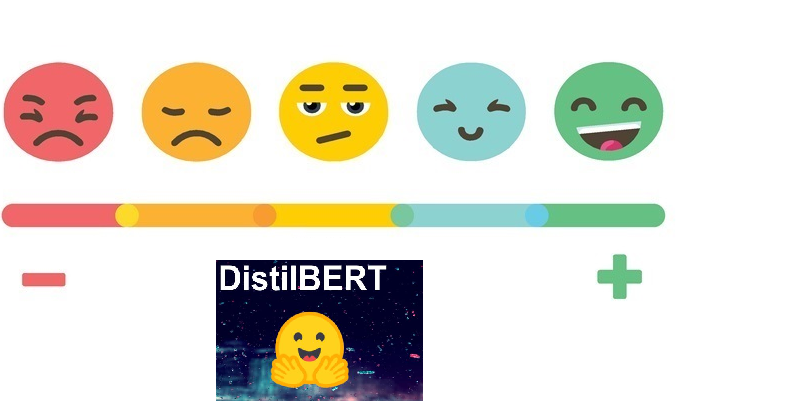

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d grikomsn/amazon-cell-phones-reviews

 57% 5.00M/8.84M [00:00<00:00, 27.5MB/s]
100% 8.84M/8.84M [00:00<00:00, 43.3MB/s]


In [6]:
!unzip "/content/amazon-cell-phones-reviews.zip"

Archive:  /content/amazon-cell-phones-reviews.zip
  inflating: 20191226-items.csv      
  inflating: 20191226-reviews.csv    


## Importing the Required Libraries

In [ ]:
!pip3 install ktrain

In [10]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os;
os.environ['CUDU_DEVICE_ORDER']='PCI_BUS_ID';
os.environ['CUDA_VISIBLE_DEVICE']="0";

In [11]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [34]:
import ktrain
from ktrain import  text

 ## pre-process the review data

In [13]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()



## Read the data

In [14]:
review_data= pd.read_csv("/content/20191226-reviews.csv")
review_data.head(10)

,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0
5,B0000SX2UC,J. White,4,"September 25, 2005",False,Worked great for me,"Hello, I have this phone and used it until I d...",NaN
6,B0000SX2UC,the cell phone store owner,5,"April 16, 2004",False,Wanna cool Nokia? You have it here!,Cool. Cheap. Color: 3 words that describe the ...,2.0
7,B0000SX2UC,Matt,4,"April 3, 2004",False,Problem with 3588i universal headset,"The 3599i is overall a nice phone, except that...",2.0
8,B0000SX2UC,Charles Cook,5,"November 24, 2003",False,cool phone!!!!!!!!,"I've never owned a Nokia phone before, so this...",7.0
9,B0000SX2UC,Amazon Customer,3,"February 2, 2004",False,Pissed off-a little bit,ok well im in school and i need the text messa...,3.0


In [15]:
print("The dataset contains {0[0]: .0f} rows and {0[1]: .0f} variables.".format(review_data.shape))

The dataset contains  67986 rows and  8 variables.


In [16]:
review_data["reviewText"]=review_data['title']+review_data["body"]

In [17]:
review_data = review_data.rename(columns = {'overall': 'rating', 'asin': 'productID'}, inplace = False)

In [18]:
review_data.dropna(axis = 0, how ='any',inplace=True) 

In [19]:
review_data['reviewText'] = review_data['reviewText'].apply(clean_text)
review_data['Num_words_text'] = review_data['reviewText'].apply(lambda x:len(str(x).split())) 

In [20]:
print(review_data['rating'].value_counts())

5    12960
1     7061
4     3280
3     2032
2     1873
Name: rating, dtype: int64


In [21]:
print(len(review_data))
max_review_data_sentence_length  = review_data['Num_words_text'].max()

print('Train Max Sentence Length :'+str(max_review_data_sentence_length))

27206
Train Max Sentence Length :4249


In [22]:
review_data['Num_words_text'].describe()

count    27206.000000
mean        74.670440
std        129.866469
min          0.000000
25%         17.000000
50%         38.000000
75%         81.000000
max       4249.000000
Name: Num_words_text, dtype: float64

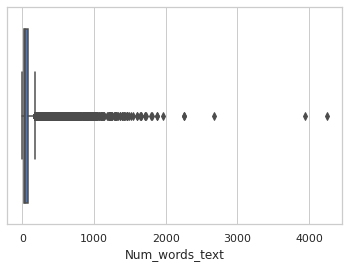

In [23]:
sns.set(style="whitegrid")
sns.boxplot(x=review_data['Num_words_text'])

### create a dataset having reviews of 100 words or less

In [24]:
mask = (review_data['Num_words_text'] < 100) & (review_data['Num_words_text'] >=20)
df_short_reviews = review_data[mask]
print('No of Short reviews')
print(len(df_short_reviews))

No of Short reviews
14036


In [25]:
mask = review_data['Num_words_text'] >= 100
df_long_reviews = review_data[mask]
print('No of Long reviews')
print(len(df_long_reviews))

No of Long reviews
5287


In [26]:
print(df_short_reviews['Num_words_text'].max())

99


In [27]:
def get_sentiment(rating):
    if rating == 5 or rating == 4 or rating ==3:
        return 1
    else:
        return 0
    

## create train and test datasets

In [28]:
filtered_data = df_short_reviews.groupby('productID').filter(lambda x: len(x) >= 20)
print(len(filtered_data))
print(filtered_data ['rating'].value_counts())

11406
5    4891
1    3348
4    1378
3     929
2     860
Name: rating, dtype: int64


In [29]:
filtered_data ['sentiment'] = filtered_data ['rating'].apply(get_sentiment)
train_data = filtered_data[['reviewText','sentiment']]
print('Train data')
print(train_data['sentiment'].value_counts())

Train data
1    7198
0    4208
Name: sentiment, dtype: int64


In [30]:
#Create Test Data
mask = review_data['Num_words_text'] < 100 
df_short_reviews = review_data[mask]
filtered_data = df_short_reviews.groupby('productID').filter(lambda x: len(x) >= 10)
print(len(filtered_data))
print(filtered_data ['rating'].value_counts())

20926
5    10199
1     5679
4     2279
3     1450
2     1319
Name: rating, dtype: int64


In [31]:
filtered_data ['sentiment'] = filtered_data ['rating'].apply(get_sentiment)
test_data = filtered_data[['reviewText','sentiment']]
print('Test data')
print(test_data['sentiment'].value_counts())

Test data
1    13928
0     6998
Name: sentiment, dtype: int64


In [32]:
train_data['sentiment'].value_counts()

1    7198
0    4208
Name: sentiment, dtype: int64

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['reviewText'].tolist(),\
                                                      train_data['sentiment'].tolist(),\
                                                      test_size=0.3,\
                                                      stratify = train_data['sentiment'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

Train data len:7984
Class distributionCounter({1: 5038, 0: 2946})
Valid data len:3422
Class distributionCounter({1: 2160, 0: 1262})


#Bulid trnsformer model

In [54]:
class_names=["Negative","Positive"]

In [55]:
model_name="distilbert-base-uncased"
trans=text.Transformer(model_name,maxlen=512,class_names=class_names)

In [56]:
train_data=trans.preprocess_train(X_train,y_train)
test_data=trans.preprocess_test(X_valid,y_valid)

preprocessing train...
language: en
train sequence lengths:
	mean : 48
	95percentile : 90
	99percentile : 97


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 49
	95percentile : 89
	99percentile : 97


In [57]:
model=trans.get_classifier()

In [58]:
learner=ktrain.get_learner(model,train_data=train_data,val_data=test_data,batch_size=16)

In [59]:
##learner.lr_find(show_plot=True,max_epochs=10)

In [60]:
learner.fit_onecycle(1e-4,5)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/5
499/499 [==============================] - 467s 919ms/step - loss: 0.3364 - accuracy: 0.8527 - val_loss: 0.2668 - val_accuracy: 0.8928
Epoch 2/5
499/499 [==============================] - 470s 938ms/step - loss: 0.2210 - accuracy: 0.9128 - val_loss: 0.2789 - val_accuracy: 0.8881
Epoch 3/5
499/499 [==============================] - 471s 941ms/step - loss: 0.1609 - accuracy: 0.9425 - val_loss: 0.3116 - val_accuracy: 0.8840
Epoch 4/5
499/499 [==============================] - 471s 941ms/step - loss: 0.0822 - accuracy: 0.9733 - val_loss: 0.3341 - val_accuracy: 0.8974
Epoch 5/5
499/499 [==============================] - 471s 940ms/step - loss: 0.0235 - accuracy: 0.9931 - val_loss: 0.4217 - val_accuracy: 0.8998


In [61]:
learner.validate()

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1262
           1       0.92      0.92      0.92      2160

    accuracy                           0.90      3422
   macro avg       0.89      0.89      0.89      3422
weighted avg       0.90      0.90      0.90      3422



array([[1091,  171],
       [ 172, 1988]])

In [66]:
learner.view_top_losses(n=5,preproc=trans)

----------
id:1115 | loss:8.67 | true:Negative | pred:Positive)

----------
id:1788 | loss:8.36 | true:Negative | pred:Positive)

----------
id:3021 | loss:8.32 | true:Negative | pred:Positive)

----------
id:2778 | loss:8.23 | true:Negative | pred:Positive)

----------
id:2690 | loss:8.11 | true:Negative | pred:Positive)



In [67]:
predictor=ktrain.get_predictor(learner.model,preproc=trans)

In [72]:
x="Pro-Good screen experience Good battery life.3 If you tired with MIUI, samsung is providing good UI experience.Cons- 1 Not a powerful processor. Too much legging.2 No back cover 3 Charging cord is too small 4 Not for game at all 5 camera quality is just Ok.6 only for normal users."

In [73]:
predictor.predict(x)

'Positive'